### Quora insincere question classification

- In part 1:
            EDA
            Preprocessing the data
            used TFIDF for feature extraction
            Experiment-1 : only derived Features + Logistic Regression and Trees
            Experiment-2 : TFIDF vectorizer + Logistic Regression
            Experiment-3 : TFIDF vectorizer + Feature Engineering + Logistic Regression.
        
    Here is the link https://www.kaggle.com/sai24kumar/qiq-classification-logistic-regression
            
            
- Part 2:
           Experiment 1: Pretrained Word Embeddings + Logistic Regression
           Experiment 2: Pretrained Word Embeddings + Multi_layer perceptron 
           Experiment 3: Pretrained Word Embeddings + Convolutional networks

In [1]:
##importing the modules
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import re
import gc
import seaborn as sbn
## for the progress bar we are importing the tqdm
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
### splitting the trainset and test set
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
### Loading the dataset
train_data=pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_data=pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

In [3]:
## displaying the dataset
display(train_data.head())

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
### Printing the missing values in the dataset
display(train_data.isnull().sum())
display(test_data.isnull().sum())

qid              0
question_text    0
target           0
dtype: int64

qid              0
question_text    0
dtype: int64

### To preprocess we are anlyzing with the google news word2vec embedding pretrained models.

### Preprocessing

- When we are using the preptrained embeddings then no need to normalize the words like converting from uppercase to lower case.
- No need to remove stopwords.
- Here we need to preprocess according to the embedding we use.

In [5]:
%%time

!unzip ../input/quora-insincere-questions-classification/embeddings.zip

Archive:  ../input/quora-insincere-questions-classification/embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  
CPU times: user 4.37 s, sys: 805 ms, total: 5.18 s
Wall time: 3min 51s


## Experiment 1: Pretrained Word Embedding + tranditional Machinelearning models

-  Here I am using the Google's word2vec pretrained model
-  This prerained model will return the embedding vector for the each word but we want the vector for the whole sentence.
- So we will average the Embedding vectors of words in a documnet

### Extracting the Features using the Pretrained word Embeddings

- Here we will load the google word2vec model with the help of gensim
- By this word to vec we will represent the words in to vector and we will average the word to vec for the whole sentence.

In [6]:
from gensim.models import KeyedVectors

In [7]:
%%time
file_name="./GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
model=KeyedVectors.load_word2vec_format(file_name,binary=True)

CPU times: user 33.7 s, sys: 4.43 s, total: 38.1 s
Wall time: 48.3 s


In [8]:
### checking the Vocabulary that the number of words are presenved by the w2v.
def vocab_build(corpus):
    vocab={}
    for text in tqdm(corpus):
        for word in text.split():
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    return vocab

def check_voc(vocab,model):
    embed_words=[]
    out_vocab={}
    total_words=0
    total_text=0
    for i in tqdm(vocab):
        try:
            vec=model[i]
            embed_words.append(vec)
            total_words+=vocab[i]
        except KeyError:
            out_vocab[i]=vocab[i]
            total_text+=vocab[i]
    print("The {:.2f}% of vocabularies have Covered of corpus".format(100*len(embed_words)/len(vocab)))
    print("The {:.2f}% of total text had coverded ".format((100*total_words/(total_words+total_text))))
    return out_vocab

In [9]:
vocabulary=vocab_build(train_data.question_text)
oov=check_voc(vocabulary,model)

100%|██████████| 508823/508823 [00:01<00:00, 260596.74it/s]

The 24.31% of vocabularies have Covered of corpus
The 78.75% of total text had coverded 


- Here it covered only few vocabulary. so only for 34% of vocabulary got the embeddings.


In [10]:
import operator
sort_oov=dict(sorted(oov.items(), key=operator.itemgetter(1),reverse=True))


In [11]:
print(list(sort_oov.keys())[:40])
del sort_oov,oov,vocabulary
gc.collect()

['to', 'a', 'of', 'and', 'India?', 'it?', 'do?', 'life?', 'you?', 'me?', 'them?', 'time?', 'world?', 'people?', 'why?', 'Quora?', '10', 'like?', 'for?', 'work?', '2017?', 'mean?', '2018?', 'country?', 'now?', 'this?', 'years?', '2017', 'not?', 'year?', '2018', 'day?', 'person?', 'engineering?', 'school?', 'so,', '-', 'I’m', 'money?', '12']


20

- In this dataset have the non english characters which are have in high frequency.
- There are special characters were associated with the numbers and characters.

In [12]:
contractions={"I'm": 'I am',
 "I'm'a": 'I am about to',
 "I'm'o": 'I am going to',
 "I've": 'I have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'd": 'I would',
 "I'd've": 'I would have',
 'Whatcha': 'What are you',
 "amn't": 'am not',
 "ain't": 'are not',
 "aren't": 'are not',
 "'cause": 'because',
 "can't": 'can not',
 "can't've": 'can not have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not',
 "daresn't": 'dare not',
 "dasn't": 'dare not',
 "didn't": 'did not',
 'didn’t': 'did not',
 "don't": 'do not',
 'don’t': 'do not',
 "doesn't": 'does not',
 "e'er": 'ever',
 "everyone's": 'everyone is',
 'finna': 'fixing to',
 'gimme': 'give me',
 "gon't": 'go not',
 'gonna': 'going to',
 'gotta': 'got to',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he've": 'he have',
 "he's": 'he is',
 "he'll": 'he will',
 "he'll've": 'he will have',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "here's": 'here is',
 "how're": 'how are',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how's": 'how is',
 "how'll": 'how will',
 "isn't": 'is not',
 "it's": 'it is',
 "'tis": 'it is',
 "'twas": 'it was',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it'd": 'it would',
 "it'd've": 'it would have',
 'kinda': 'kind of',
 "let's": 'let us',
 'luv': 'love',
 "ma'am": 'madam',
 "may've": 'may have',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "ne'er": 'never',
 "o'": 'of',
 "o'clock": 'of the clock',
 "ol'": 'old',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "o'er": 'over',
 "shan't": 'shall not',
 "sha'n't": 'shall not',
 "shalln't": 'shall not',
 "shan't've": 'shall not have',
 "she's": 'she is',
 "she'll": 'she will',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so've": 'so have',
 "so's": 'so is',
 "somebody's": 'somebody is',
 "someone's": 'someone is',
 "something's": 'something is',
 'sux': 'sucks',
 "that're": 'that are',
 "that's": 'that is',
 "that'll": 'that will',
 "that'd": 'that would',
 "that'd've": 'that would have',
 'em': 'them',
 "there're": 'there are',
 "there's": 'there is',
 "there'll": 'there will',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "these're": 'these are',
 "they're": 'they are',
 "they've": 'they have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "this's": 'this is',
 "those're": 'those are',
 "to've": 'to have',
 'wanna': 'want to',
 "wasn't": 'was not',
 "we're": 'we are',
 "we've": 'we have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "weren't": 'were not',
 "what're": 'what are',
 "what'd": 'what did',
 "what've": 'what have',
 "what's": 'what is',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "when've": 'when have',
 "when's": 'when is',
 "where're": 'where are',
 "where'd": 'where did',
 "where've": 'where have',
 "where's": 'where is',
 "which's": 'which is',
 "who're": 'who are',
 "who've": 'who have',
 "who's": 'who is',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who'd": 'who would',
 "who'd've": 'who would have',
 "why're": 'why are',
 "why'd": 'why did',
 "why've": 'why have',
 "why's": 'why is',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "you're": 'you are',
 "you've": 'you have',
 "you'll've": 'you shall have',
 "you'll": 'you will',
 "you'd": 'you would',
 "you'd've": 'you would have',
 'jan.': 'january',
 'feb.': 'february',
 'mar.': 'march',
 'apr.': 'april',
 'jun.': 'june',
 'jul.': 'july',
 'aug.': 'august',
 'sep.': 'september',
 'oct.': 'october',
 'nov.': 'november',
 'dec.': 'december',
 'I’m': 'I am',
 'I’m’a': 'I am about to',
 'I’m’o': 'I am going to',
 'I’ve': 'I have',
 'I’ll': 'I will',
 'I’ll’ve': 'I will have',
 'I’d': 'I would',
 'I’d’ve': 'I would have',
 'amn’t': 'am not',
 'ain’t': 'are not',
 'aren’t': 'are not',
 '’cause': 'because',
 'can’t': 'can not',
 'can’t’ve': 'can not have',
 'could’ve': 'could have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'daren’t': 'dare not',
 'daresn’t': 'dare not',
 'dasn’t': 'dare not',
 'doesn’t': 'does not',
 'e’er': 'ever',
 'everyone’s': 'everyone is',
 'gon’t': 'go not',
 'hadn’t': 'had not',
 'hadn’t’ve': 'had not have',
 'hasn’t': 'has not',
 'haven’t': 'have not',
 'he’ve': 'he have',
 'he’s': 'he is',
 'he’ll': 'he will',
 'he’ll’ve': 'he will have',
 'he’d': 'he would',
 'he’d’ve': 'he would have',
 'here’s': 'here is',
 'how’re': 'how are',
 'how’d': 'how did',
 'how’d’y': 'how do you',
 'how’s': 'how is',
 'how’ll': 'how will',
 'isn’t': 'is not',
 'it’s': 'it is',
 '’tis': 'it is',
 '’twas': 'it was',
 'it’ll': 'it will',
 'it’ll’ve': 'it will have',
 'it’d': 'it would',
 'it’d’ve': 'it would have',
 'let’s': 'let us',
 'ma’am': 'madam',
 'may’ve': 'may have',
 'mayn’t': 'may not',
 'might’ve': 'might have',
 'mightn’t': 'might not',
 'mightn’t’ve': 'might not have',
 'must’ve': 'must have',
 'mustn’t': 'must not',
 'mustn’t’ve': 'must not have',
 'needn’t': 'need not',
 'needn’t’ve': 'need not have',
 'ne’er': 'never',
 'o’': 'of',
 'o’clock': 'of the clock',
 'ol’': 'old',
 'oughtn’t': 'ought not',
 'oughtn’t’ve': 'ought not have',
 'o’er': 'over',
 'shan’t': 'shall not',
 'sha’n’t': 'shall not',
 'shalln’t': 'shall not',
 'shan’t’ve': 'shall not have',
 'she’s': 'she is',
 'she’ll': 'she will',
 'she’d': 'she would',
 'she’d’ve': 'she would have',
 'should’ve': 'should have',
 'shouldn’t': 'should not',
 'shouldn’t’ve': 'should not have',
 'so’ve': 'so have',
 'so’s': 'so is',
 'somebody’s': 'somebody is',
 'someone’s': 'someone is',
 'something’s': 'something is',
 'that’re': 'that are',
 'that’s': 'that is',
 'that’ll': 'that will',
 'that’d': 'that would',
 'that’d’ve': 'that would have',
 'there’re': 'there are',
 'there’s': 'there is',
 'there’ll': 'there will',
 'there’d': 'there would',
 'there’d’ve': 'there would have',
 'these’re': 'these are',
 'they’re': 'they are',
 'they’ve': 'they have',
 'they’ll': 'they will',
 'they’ll’ve': 'they will have',
 'they’d': 'they would',
 'they’d’ve': 'they would have',
 'this’s': 'this is',
 'those’re': 'those are',
 'to’ve': 'to have',
 'wasn’t': 'was not',
 'we’re': 'we are',
 'we’ve': 'we have',
 'we’ll': 'we will',
 'we’ll’ve': 'we will have',
 'we’d': 'we would',
 'we’d’ve': 'we would have',
 'weren’t': 'were not',
 'what’re': 'what are',
 'what’d': 'what did',
 'what’ve': 'what have',
 'what’s': 'what is',
 'what’ll': 'what will',
 'what’ll’ve': 'what will have',
 'when’ve': 'when have',
 'when’s': 'when is',
 'where’re': 'where are',
 'where’d': 'where did',
 'where’ve': 'where have',
 'where’s': 'where is',
 'which’s': 'which is',
 'who’re': 'who are',
 'who’ve': 'who have',
 'who’s': 'who is',
 'who’ll': 'who will',
 'who’ll’ve': 'who will have',
 'who’d': 'who would',
 'who’d’ve': 'who would have',
 'why’re': 'why are',
 'why’d': 'why did',
 'why’ve': 'why have',
 'why’s': 'why is',
 'will’ve': 'will have',
 'won’t': 'will not',
 'won’t’ve': 'will not have',
 'would’ve': 'would have',
 'wouldn’t': 'would not',
 'wouldn’t’ve': 'would not have',
 'y’all': 'you all',
 'y’all’re': 'you all are',
 'y’all’ve': 'you all have',
 'y’all’d': 'you all would',
 'y’all’d’ve': 'you all would have',
 'you’re': 'you are',
 'you’ve': 'you have',
 'you’ll’ve': 'you shall have',
 'you’ll': 'you will',
 'you’d': 'you would',
 'you’d’ve': 'you would have'}

def contraction_fix(word):
    try:
        a=contractions[word]
    except KeyError:
        a=word
    return a

In [13]:
import re
### Preprocess the train dataset 
def Preprocess(x):
    remove_words=["to","a","and","of"]
    
    x=" ".join([contraction_fix(w) for w in x.split() if w not in remove_words])        
    x=re.sub(r"[^a-zA-Z0-9]"," ",x)
    x=re.sub(r'[0-9]{5,}','##### ',x)
    x=re.sub(r'[0-9]{4}',"#### ",x)
    x=re.sub(r'[0-9]{3}','### ',x)
    x=re.sub(r'[0-9]{2}',"## ",x)
    x=re.sub(r'[0-9]{1}',"# ",x)
    return x

In [14]:
text_data=train_data.question_text.apply(Preprocess)
vocab=vocab_build(text_data)
oov=check_voc(vocab,model)

100%|██████████| 223181/223181 [00:00<00:00, 252193.81it/s]


The 64.57% of vocabularies have Covered of corpus
The 98.93% of total text had coverded 


In [15]:
sort_oov=dict(sorted(oov.items(), key=operator.itemgetter(1),reverse=True))
print(list(sort_oov.keys())[:20])
### analysis over we are deleting the unnecessary variables and dealocate those variables 
del text_data,vocab,oov,sort_oov
gc.collect()

['to', 'a', 'of', 'and', 'WW#', 'favourite', 'bitcoin', 'colour', 'H#', 'centre', 'Quorans', 'cryptocurrency', 'Snapchat', 'travelling', 'B#', 'counselling', 'A#', 'Brexit', 'btech', 'cryptocurrencies']


0

- Furthur Preprocess do spell checking and correct those spellings

In [16]:
### Preprocessing will be doing according to the Google word2vec
train_data.question_text=train_data.question_text.apply(Preprocess)
train_data["num_words"]=train_data.question_text.apply(lambda x:len(x.split()))

## Getting Sentence vector from a word2vec Pretrained Embedding models

**Some of the Ideas:**

Idea 1:
        - we will average the all the word embeddings for a each doc .
        - So that we can get a fixed 300 dimensional vector representation for a document
        
Idea 2:
        - concatenate the embedded words in a each document.
        - But the problem is length of the vector varies with the length of the document.
        

### Using Average word2vec

In [17]:
%%time
## defing the function for the getting embedding vectores for the doc i.e Doc2Vec
def Doc2Vec(corpus):
    vector_sent=[]
    for i in tqdm(corpus):
        words=i.split()
        count=0
        avg=np.zeros((300,))
        for word in words:
            try:
                avg=avg+model[word]
                count+=1
            except KeyError:
                continue
        if(count!=0):
            avg=avg/count
        else:
            avg=np.zeros((300,))
        vector_sent.append(avg)
        del avg
        
        
    return np.array(vector_sent)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [18]:
x_train,x_val,y_train,y_val=train_test_split(train_data.question_text,train_data.target.values,stratify=train_data.target.values)
## printing the shapes of the datasets
print("The shape of the train dataset :",x_train.shape,y_train.shape)
print("The shape of the Test dataset :",x_val.shape,y_val.shape)

The shape of the train dataset : (979591,) (979591,)
The shape of the Test dataset : (326531,) (326531,)


In [19]:
x_train=Doc2Vec(x_train)
x_val=Doc2Vec(x_val)

100%|██████████| 326531/326531 [00:25<00:00, 12680.76it/s]


### Building the Model

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [21]:
model_log=LogisticRegression(C=15,max_iter=300)
model_log.fit(x_train,y_train)
train_pre=model_log.predict(x_train)
val_pre=model_log.predict(x_val)

print("-------------Evalution Scores------------------")
print("F1-score of Trainset :",metrics.f1_score(y_train,train_pre))
print("F1-score of Valset :",metrics.f1_score(y_val,val_pre))

-------------Evalution Scores------------------
F1-score of Trainset : 0.41434758467518046
F1-score of Valset : 0.4098001460726379


- In previous notebook i used a bag of words representation + Logistic regression i got 55% f1-score but here is getting very low even though it has semantic representation.
- This is because here we lost lot of information . In bag of words there can be words which are relevent and irrelevent so logistic regression will deffirentiate beween those words . but here both the relevent and non relevent words are to averaged .

In [22]:
del model_log,x_train,y_train,y_val,x_val
gc.collect()


84

## Paragraph embeddings

- There are some sentence techniques 
    They are :
            1.Average word2vec (discussed in the above)
            2.Doc2vec also called as paragraph embedding
            3.SentenceBert
            4.InferSent
            5.Universal Sentence Encoder.
 Ref: https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/ 
 
 In this experiment i am using only doc2vec method

### Doc2vec
- step 1: preprocess and tokenize the text data.
- step 2: prepare the tagged document 
- step 3: Train with the PV-DM or PV-DBOW
- step 4: get the Paragraph embeddings by infering the sentences

NOte : I am not goind to use this . beacause it is taking lot of time to train and embede the documents.

In [23]:
'''
## importing the neceesary libraries 
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
import re 
def Preprocess_doc(corpus):
    doc=[]
    for text in tqdm(corpus):
        text=text.lower()
        text=text.strip()
        text=re.sub(r"[^a-zA-Z]"," ",text)
        word=[i for i in text.split() if(len(i)>1 and i.isalpha() and (i not in stop_words))]
        text=[ps.stem(i) for i in word]
        doc.append(text)
    return doc
corpus=Preprocess_doc(train_data.question_text)
#converting the tokinezed documents to a tagged Documents
tagged_data =[]
for i,doc in tqdm(enumerate(corpus)):
    if(len(doc)==0):
        doc=["unknown"]
    tagged_data.append(TaggedDocument(doc,[i]))
    %%time
### Train the model
model = Doc2Vec(tagged_data, vector_size=30, window=2, min_count=1, workers=-1, epochs = 100)
# Save trained doc2vec model
model.save("test_doc2vec.model")

'''



'\n## importing the neceesary libraries \nfrom gensim.models.doc2vec import Doc2Vec,TaggedDocument\nimport re \ndef Preprocess_doc(corpus):\n    doc=[]\n    for text in tqdm(corpus):\n        text=text.lower()\n        text=text.strip()\n        text=re.sub(r"[^a-zA-Z]"," ",text)\n        word=[i for i in text.split() if(len(i)>1 and i.isalpha() and (i not in stop_words))]\n        text=[ps.stem(i) for i in word]\n        doc.append(text)\n    return doc\ncorpus=Preprocess_doc(train_data.question_text)\n#converting the tokinezed documents to a tagged Documents\ntagged_data =[]\nfor i,doc in tqdm(enumerate(corpus)):\n    if(len(doc)==0):\n        doc=["unknown"]\n    tagged_data.append(TaggedDocument(doc,[i]))\n    %%time\n### Train the model\nmodel = Doc2Vec(tagged_data, vector_size=30, window=2, min_count=1, workers=-1, epochs = 100)\n# Save trained doc2vec model\nmodel.save("test_doc2vec.model")\n\n'

## Experiment :2 Pretrained Embeddings + MLP

In [24]:
### importing the libraire
from keras.layers import Conv1D,Flatten,Dense,BatchNormalization,Embedding,MaxPooling1D,Input
from keras.layers import SpatialDropout1D,Dropout
from keras.layers.merge import concatenate
from keras.models import Model,Sequential
from keras.activations import relu
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [25]:
## we need to prepare the input to the Embedding layer that it was accepted
max_lenth=30
vec_size=300
# get a word to index dictonary and and encoded sentence
## step 1: defining a fit_on_text functions it will return the vecabular to index dictonary and 
## encoded sentence

def get_word_index(corpus):
    vocab=vocab_build(corpus)
    word_index=dict((w,i+1) for i,w in enumerate(list(vocab.keys())))
    return word_index

    
def fit_on_text(corpus,word_index):
    sent=[]
    for text in tqdm(corpus):
        li=[word_index[w] for w in text.split()]
        sent.append(li)
    return sent

# word_index and encoded sentence 
word_index=get_word_index(train_data.question_text)
encoded_docs=fit_on_text(train_data.question_text,word_index)

## vocabulary size
vocab_size=len(word_index)+1

100%|██████████| 1306122/1306122 [00:07<00:00, 172044.35it/s]


In [26]:
print("The Number of Vocabularies are in the dataset is :",vocab_size)

## step 2: padding the sequence to a maximum length
## the pad_to_seqeucbe method wiill expect the input of encoded and max leght, and where to pad this is with the zeros
## i.e post or pre 
padded_doc=pad_sequences(encoded_docs,maxlen=max_lenth,padding="post")

The Number of Vocabularies are in the dataset is : 223182


In [27]:
## step 3: constructinng embedding matrix for the corpus vocabulary using the pretrained embeddings:
## here each row will have the emedding vector for each unique word
count=0
embedding_mat=np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    try:
        vec=model[word]
        embedding_mat[i]=vec
    except KeyError:
        count+=1
        continue

print("Number of Out of Vocabulary",count)

100%|██████████| 223181/223181 [00:01<00:00, 194072.99it/s]

Number of Out of Vocabulary 79072


In [28]:
### splitting dataset in to train_set and test_set
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(np.array(padded_doc),train_data.target,test_size=0.2,stratify=train_data.target)

## Building the model

In [29]:
### defing the model
classfy=Sequential()
classfy.add(Embedding(vocab_size,300,weights=[embedding_mat],input_length=max_lenth,trainable=False))
classfy.add(Flatten())
classfy.add(Dense(256,activation="relu"))
classfy.add(Dense(128,activation="relu"))
classfy.add(Dense(1,activation="sigmoid"))

In [30]:
classfy.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           66954600  
_________________________________________________________________
flatten (Flatten)            (None, 9000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2304256   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 69,291,881
Trainable params: 2,337,281
Non-trainable params: 66,954,600
_________________________________________________________________


In [31]:
my_callbacks=[EarlyStopping(patience=2,monitor="val_loss")]

In [32]:
classfy.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
classfy.fit(x_train,y_train,epochs=5,validation_data=(x_val,y_val),callbacks=my_callbacks,batch_size=128)

Epoch 1/5
8164/8164 [==============================] - 37s 4ms/step - loss: 0.1248 - accuracy: 0.9512 - val_loss: 0.1203 - val_accuracy: 0.9524
Epoch 2/5
8164/8164 [==============================] - 39s 5ms/step - loss: 0.1089 - accuracy: 0.9573 - val_loss: 0.1193 - val_accuracy: 0.9533
Epoch 3/5
8164/8164 [==============================] - 38s 5ms/step - loss: 0.0906 - accuracy: 0.9651 - val_loss: 0.1235 - val_accuracy: 0.9522
Epoch 4/5
8164/8164 [==============================] - 39s 5ms/step - loss: 0.0677 - accuracy: 0.9747 - val_loss: 0.1494 - val_accuracy: 0.9491


### Evalution of Validation data 

- here the Metric we using is f1_score and roc_auc_score 

In [33]:
val_pre=classfy.predict(x_val)
predicts=[]
threshold=0.3
for i in val_pre:
    if(i<threshold):
        predicts.append(0)
    else:
        predicts.append(1)

print("AUC and ROC score is :",metrics.roc_auc_score(y_val,val_pre))
print("F1_score :",metrics.f1_score(y_val,predicts))

AUC and ROC score is : 0.9369327887821686
F1_score : 0.5881290534438879


### Creating the Submission file from the dataset

In [34]:
clean_test_data=test_data.question_text.apply(Preprocess)


In [35]:
def fit_on_test_text(corpus,word_index):
    sent=[]
    for text in tqdm(corpus):
       
        li=[]
        for w in text.split():
            try:
                li.append(word_index[w])
            except KeyError:
                li.append(0)
        sent.append(li)
    return sent

In [36]:
def Submission_file(model,name):
    test_encode=fit_on_test_text(clean_test_data,word_index)
    test_pad=pad_sequences(test_encode,maxlen=max_lenth,padding="post")
    test_predict=model.predict(test_pad)
    predicts=[]
    threshold=0.3
    for i in test_predict:
        if(i<threshold):
            predicts.append(0)
        else:
            predicts.append(1)
    submit=pd.DataFrame()
    submit["qid"]=test_data.qid
    submit["prediction"]=predicts
    submit.to_csv(name,index=False)
    return submit

In [37]:
df_mlp=Submission_file(classfy,"submit_mlp.csv")

100%|██████████| 375806/375806 [00:02<00:00, 163101.44it/s]


## Experiment 3: Pretrained Embedding + Convolutional

### Model 1:
- here i take the filter size of 3 (like tri-gram)
- here i used the 2 convolutions 

In [38]:

model_cnn=Sequential()
model_cnn.add(Embedding(vocab_size,300,weights=[embedding_mat],input_length=max_lenth,trainable=False))
model_cnn.add(Conv1D(64,3,activation="relu",input_shape=(max_lenth,vec_size)))
model_cnn.add(MaxPooling1D())
model_cnn.add(Conv1D(32,3,activation="relu"))
model_cnn.add(Flatten())
model_cnn.add(Dense(256,activation="relu"))
model_cnn.add(Dense(128,activation="relu"))
model_cnn.add(Dense(1,activation="sigmoid"))

In [39]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           66954600  
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 64)            57664     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 32)            6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               98560     
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [40]:
model_cnn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model_cnn.fit(x_train,y_train,epochs=5,validation_data=(x_val,y_val),callbacks=my_callbacks,batch_size=128)

Epoch 1/5
8164/8164 [==============================] - 44s 5ms/step - loss: 0.1172 - accuracy: 0.9536 - val_loss: 0.1114 - val_accuracy: 0.9551
Epoch 2/5
8164/8164 [==============================] - 44s 5ms/step - loss: 0.1052 - accuracy: 0.9580 - val_loss: 0.1082 - val_accuracy: 0.9565
Epoch 3/5
8164/8164 [==============================] - 47s 6ms/step - loss: 0.0991 - accuracy: 0.9600 - val_loss: 0.1082 - val_accuracy: 0.9572
Epoch 4/5
8164/8164 [==============================] - 45s 5ms/step - loss: 0.0942 - accuracy: 0.9616 - val_loss: 0.1122 - val_accuracy: 0.9572
Epoch 5/5
8164/8164 [==============================] - 45s 5ms/step - loss: 0.0898 - accuracy: 0.9630 - val_loss: 0.1111 - val_accuracy: 0.9571


In [41]:
val_pre=model_cnn.predict(x_val)
predicts=[]
threshold=0.3
for i in val_pre:
    if(i<threshold):
        predicts.append(0)
    else:
        predicts.append(1)

print("AUC and ROC score is :",metrics.roc_auc_score(y_val,val_pre))
print("F1_score :",metrics.f1_score(y_val,predicts))

AUC and ROC score is : 0.9571115326691653
F1_score : 0.6486150367439231


In [42]:
## creating the submission File for convolutional networks
df_mlp=Submission_file(model_cnn,"submit_model_cnn.csv")

100%|██████████| 375806/375806 [00:03<00:00, 107207.13it/s]


### model 2:
- Here i use n_gram filters 3,5,7 size of filters and i will combine those 

In [43]:
input_=Input((max_lenth,))
emb_vec=Embedding(vocab_size,300,weights=[embedding_mat],input_length=max_lenth,trainable=False)(input_)
## 3-gram convolution
out_3g=Conv1D(64,3,activation="relu",input_shape=(max_lenth,vec_size))(emb_vec)
out_3g=MaxPooling1D()(out_3g)
out_3g=SpatialDropout1D(0.5)(out_3g)
out_3g=Conv1D(64,3,activation="relu")(out_3g)
out_3g=MaxPooling1D()(out_3g)
out_3g=SpatialDropout1D(0.5)(out_3g)
out_3g=Flatten()(out_3g)
## 5-gram convolutin
out_5g=Conv1D(64,5,activation="relu",input_shape=(max_lenth,vec_size))(emb_vec)
out_5g=MaxPooling1D()(out_5g)
out_5g=SpatialDropout1D(0.5)(out_5g)
out_5g=Conv1D(64,5,activation="relu")(out_5g)
out_5g=MaxPooling1D()(out_5g)
out_5g=SpatialDropout1D(0.5)(out_5g)
out_5g=Flatten()(out_5g)
## 7-gram convolution
out_7g=Conv1D(64,7,activation="relu",input_shape=(max_lenth,vec_size))(emb_vec)
out_7g=MaxPooling1D()(out_7g)
out_7g=SpatialDropout1D(0.5)(out_7g)
out_7g=Conv1D(64,7,activation="relu")(out_7g)
out_7g=MaxPooling1D()(out_7g)
out_7g=SpatialDropout1D(0.5)(out_7g)
out_7g=Flatten()(out_7g)

#concatenate all those outputs
com_grams=concatenate([out_3g,out_5g,out_7g],axis=-1)
output=Dense(256,activation="relu")(com_grams)

output=Dense(1,activation="sigmoid")(output)

model_cnn_2=Model(inputs=input_,outputs=output)

In [44]:
model_cnn_2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 300)      66954600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 28, 64)       57664       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 26, 64)       96064       embedding_2[0][0]                
_______________________________________________________________________________________

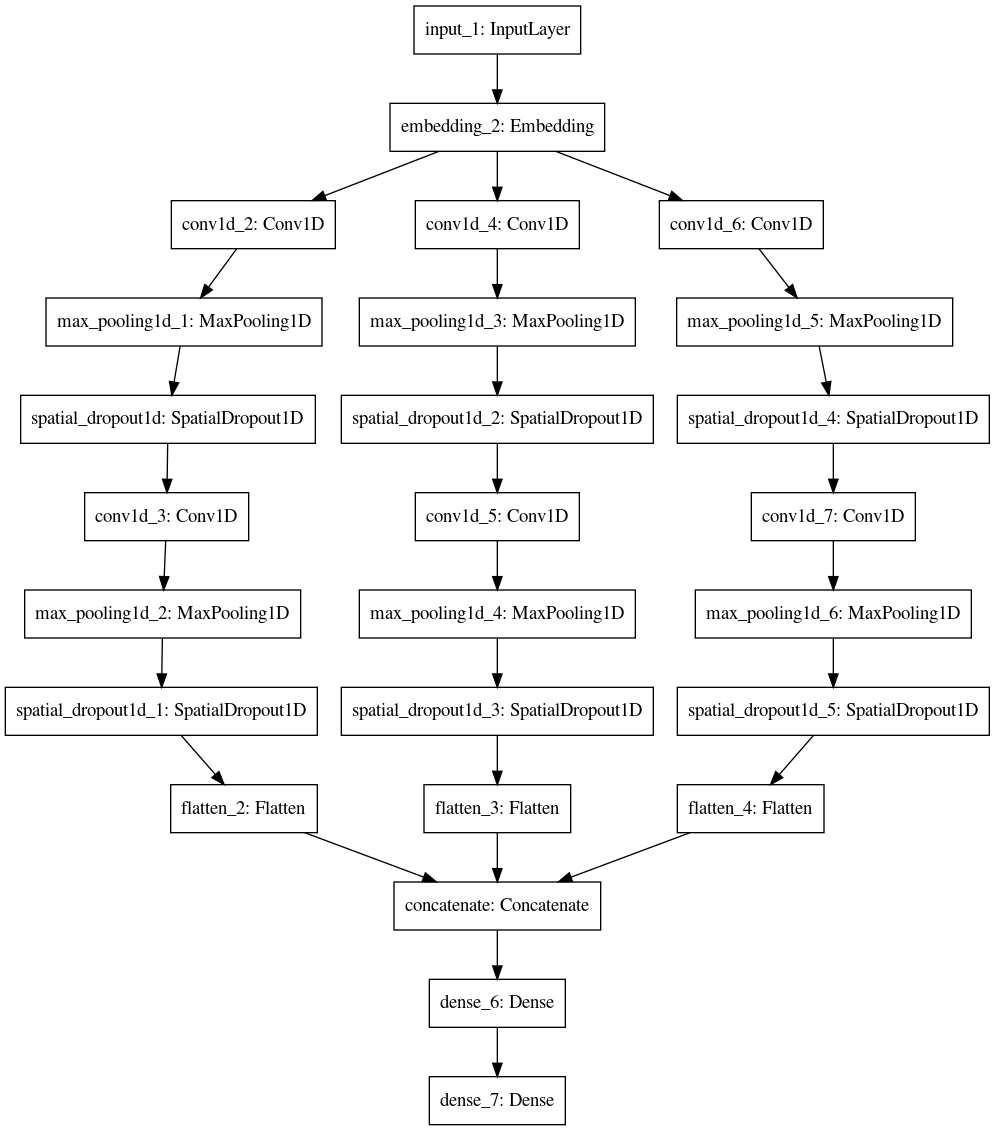

In [45]:
## plotting the model
plot_model(model_cnn_2)

In [46]:
model_cnn_2.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model_cnn_2.fit(x_train,y_train,epochs=5,validation_data=(x_val,y_val),callbacks=my_callbacks,batch_size=256)

Epoch 1/5
4082/4082 [==============================] - 52s 13ms/step - loss: 0.1278 - accuracy: 0.9498 - val_loss: 0.1160 - val_accuracy: 0.9542
Epoch 2/5
4082/4082 [==============================] - 52s 13ms/step - loss: 0.1160 - accuracy: 0.9537 - val_loss: 0.1121 - val_accuracy: 0.9548
Epoch 3/5
4082/4082 [==============================] - 52s 13ms/step - loss: 0.1112 - accuracy: 0.9552 - val_loss: 0.1147 - val_accuracy: 0.9557
Epoch 4/5
4082/4082 [==============================] - 50s 12ms/step - loss: 0.1077 - accuracy: 0.9565 - val_loss: 0.1101 - val_accuracy: 0.9555
Epoch 5/5
4082/4082 [==============================] - 52s 13ms/step - loss: 0.1044 - accuracy: 0.9575 - val_loss: 0.1086 - val_accuracy: 0.9566


In [47]:
val_pre=model_cnn_2.predict(x_val)
predicts=[]
threshold=0.3
for i in val_pre:
    if(i<threshold):
        predicts.append(0)
    else:
        predicts.append(1)

print("AUC and ROC score is :",metrics.roc_auc_score(y_val,val_pre))
print("F1_score :",metrics.f1_score(y_val,predicts))

AUC and ROC score is : 0.958631840954153
F1_score : 0.6410433123045115


In [48]:
df=Submission_file(model_cnn_2,"submission.csv")

100%|██████████| 375806/375806 [00:02<00:00, 165179.87it/s]
